In [6]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9,5)
plt.rcParams["axes.grid"] = True

def find_project_root(max_up=5):
    """
    notebooks/ içinden çalışsan bile proje kökünü bul:
    - src klasörü ya da .git varsa kök kabul edilir
    """
    p = Path.cwd().resolve()
    for _ in range(max_up+1):
        if (p / "src").exists() or (p / ".git").exists():
            return p
        p = p.parent
    return Path.cwd().resolve()

ROOT = find_project_root()
XLSX = ROOT / "outputs" / "eval" / "mila_eval.xlsx"
OUT  = ROOT / "outputs" / "eda"
OUT.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", ROOT)
print("XLSX exists:", XLSX.exists(), "|", XLSX)


PROJECT_ROOT: C:\Users\User\Desktop\mila-ai-eval
XLSX exists: True | C:\Users\User\Desktop\mila-ai-eval\outputs\eval\mila_eval.xlsx


In [7]:
if not XLSX.exists():
    raise SystemExit(
        f"Excel raporu bulunamadı:\n{XLSX}\n\n"
        "Önce şu komutu proje KÖK klasöründe çalıştırın (Windows CMD):\n\n"
        "python src\\eval_pipeline.py ^\n"
        "  --in-json data\\raw\\20-sohbet-trendyol-mila.json ^\n"
        "  --prompt src\\prompt_template.txt ^\n"
        "  --pred-out outputs\\predictions\\preds_mila.csv ^\n"
        "  --excel-out outputs\\eval\\mila_eval.xlsx ^\n"
        "  --cm-dir outputs\\eval\\confusions ^\n"
        "  --model gpt-5-nano\n"
    )


In [8]:
df = pd.read_excel(pd.ExcelFile(XLSX), sheet_name="data")
print("N =", len(df))
df.head(2)


N = 40


,conversation_id,dialog_text,gold_sentiment,gold_intent,gold_yanit_durumu,gold_tur,pred_yanit_durumu,pred_sentiment,pred_tur,pred_intent,pred_intent_detay,prompt_used,raw_model_output
0,90001,[BOT] Merhaba! Ben AI Asistan. Size nasıl yard...,Pozitif,Eksik ürün,Çözüldü,Şikayet,Çözüldü,Pozitif,Sorun,Eksik ürün,Sipariş teslimatında eksik ürün,ANLAM ÖNCELİKLİ — KATMANLI SINIFLANDIRMA (fina...,"{""final"": {""yanit_durumu"": ""Çözüldü"", ""sentime..."
1,90002,[BOT] Merhaba! Ben AI Asistan. Size nasıl yard...,Negatif,Şifre sıfırlama,Çözülemedi,Sorun,Çözülemedi,Negatif,Bilgi alma,Şifre sıfırlama,E-posta linki gelmemesi,ANLAM ÖNCELİKLİ — KATMANLI SINIFLANDIRMA (fina...,"{""final"": {""yanit_durumu"": ""Çözülemedi"", ""sent..."


In [9]:
import numpy as np

def plot_side_by_side_counts(gold_s, pred_s, title, top_n=None, rotate=45, fname=None):
    g = gold_s.dropna().astype(str)
    p = pred_s.dropna().astype(str)
    vg = g.value_counts()
    vp = p.value_counts()

    idx = vg.index.tolist()
    if top_n:
        idx = idx[:top_n]
    extra = [c for c in vp.index.tolist() if c not in idx]
    idx = idx + extra

    G = vg.reindex(idx).fillna(0)
    P = vp.reindex(idx).fillna(0)

    x = np.arange(len(idx)); w = 0.42
    fig, ax = plt.subplots()
    ax.bar(x - w/2, G.values, width=w, label="Gold (Manual)")
    ax.bar(x + w/2, P.values, width=w, label="LLM (Pred)")
    ax.set_title(title); ax.set_ylabel("Adet")
    ax.set_xticks(x); ax.set_xticklabels(idx, rotation=rotate, ha="right")
    ax.legend(); plt.tight_layout()
    if fname: plt.savefig(OUT / fname, dpi=180)
    plt.show()

def acc_f1(g, p):
    g = pd.Series(g).astype(str)
    p = pd.Series(p).astype(str)
    acc = (g.values == p.values).mean()
    classes = sorted(set(g.unique()) | set(p.unique()))
    f1s = []
    for c in classes:
        tp = ((g==c)&(p==c)).sum()
        fp = ((g!=c)&(p==c)).sum()
        fn = ((g==c)&(p!=c)).sum()
        prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
        rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
        f1   = (2*prec*rec)/(prec+rec) if (prec+rec)>0 else 0.0
        f1s.append(f1)
    return float(acc), float(np.mean(f1s) if f1s else 0.0)


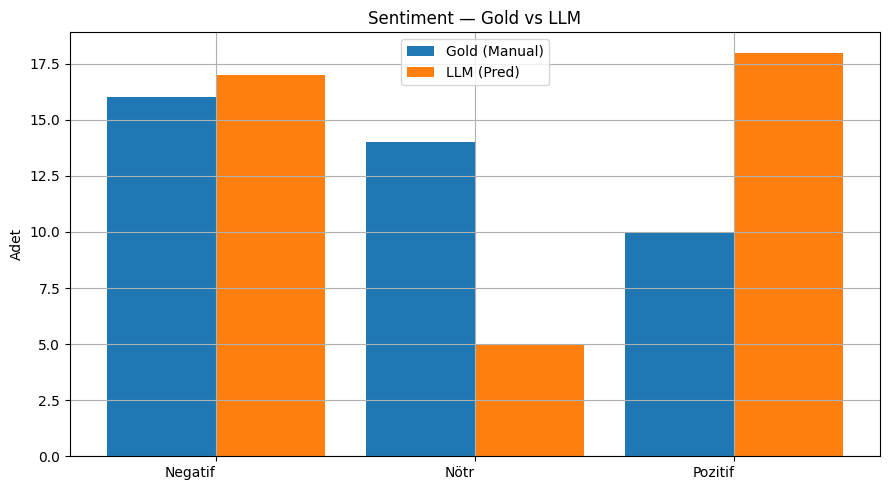

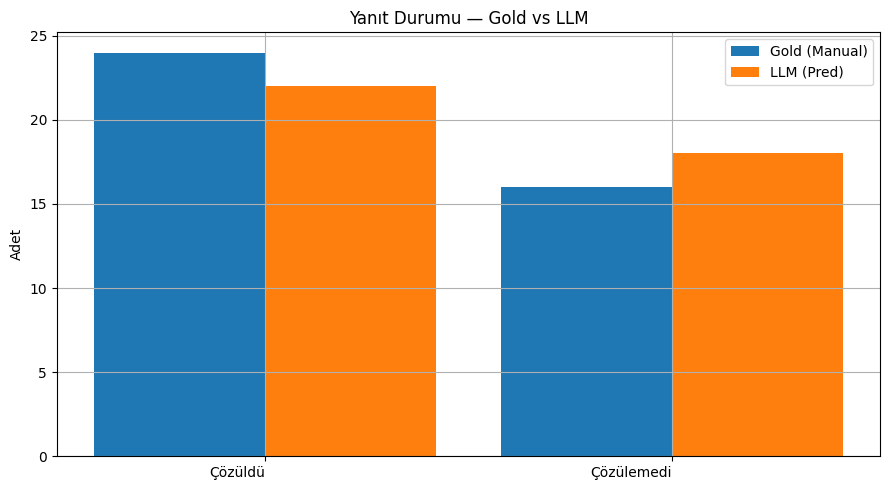

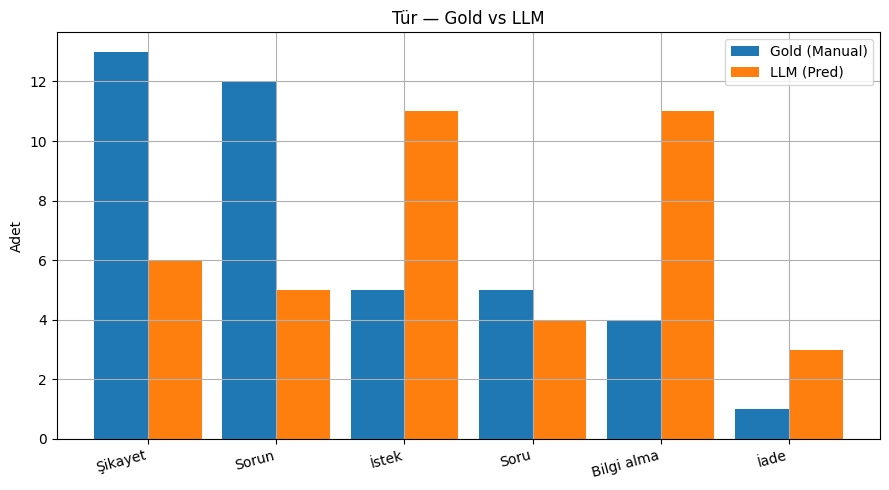

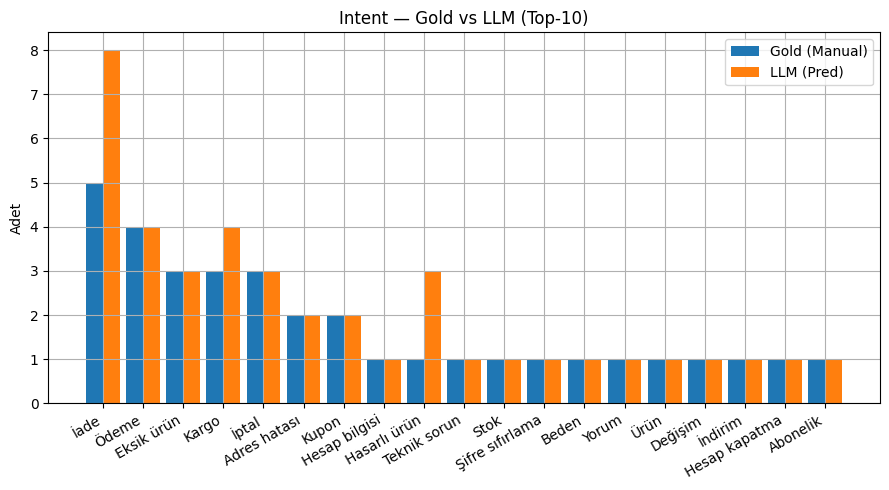

In [10]:
# Sentiment
plot_side_by_side_counts(
    df["gold_sentiment"], df["pred_sentiment"],
    title="Sentiment — Gold vs LLM", fname="dist_sentiment.png", rotate=0
)

# Yanıt Durumu
plot_side_by_side_counts(
    df["gold_yanit_durumu"], df["pred_yanit_durumu"],
    title="Yanıt Durumu — Gold vs LLM", fname="dist_yanit_durumu.png", rotate=0
)

# Tür (varsa)
if "gold_tur" in df.columns and "pred_tur" in df.columns:
    plot_side_by_side_counts(
        df["gold_tur"], df["pred_tur"],
        title="Tür — Gold vs LLM", fname="dist_tur.png", rotate=15
    )

# Intent — Top-10
plot_side_by_side_counts(
    df["gold_intent"], df["pred_intent"],
    title="Intent — Gold vs LLM (Top-10)", top_n=10, fname="dist_intent_top10.png", rotate=30
)


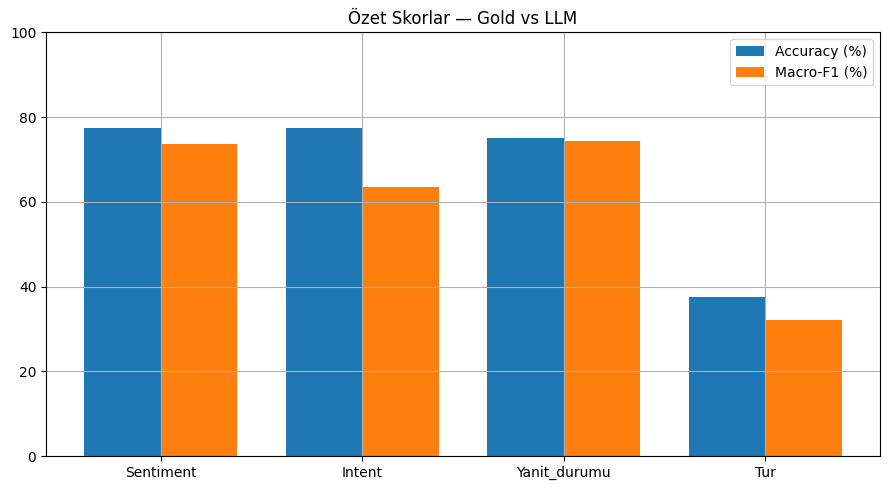

In [11]:
scores = {}
for col in ["sentiment","intent","yanit_durumu","tur"]:
    g, p = f"gold_{col}", f"pred_{col}"
    if g in df.columns and p in df.columns and df[g].notna().any() and df[p].notna().any():
        scores[col] = acc_f1(df[g], df[p])

labels = list(scores.keys())
accs   = [scores[k][0] for k in labels]
f1s    = [scores[k][1] for k in labels]

x = np.arange(len(labels)); w = 0.38
fig, ax = plt.subplots()
ax.bar(x - w/2, [a*100 for a in accs], width=w, label="Accuracy (%)")
ax.bar(x + w/2, [f*100 for f in f1s],  width=w, label="Macro-F1 (%)")
ax.set_title("Özet Skorlar — Gold vs LLM")
ax.set_xticks(x); ax.set_xticklabels([k.capitalize() for k in labels])
ax.set_ylim(0, 100)
ax.legend()
plt.tight_layout()
plt.savefig(OUT / "scores_overview.png", dpi=180)
plt.show()
